In [19]:
#Reproduce : https://github.com/higgsfield/Capsule-Network-Tutorial/blob/master/Capsule%20Network.ipynb
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torchvision import datasets, transforms

USE_CUDA = True

In [2]:
class Mnist:
    def __init__(self, batch_size):
        dataset_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

        train_dataset = datasets.MNIST('../data', train=True, download=True, transform=dataset_transform)
        test_dataset = datasets.MNIST('../data', train=False, download=True, transform=dataset_transform)
        
        self.train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [4]:

class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=kernel_size,
                               stride=1
                             )

    def forward(self, x):
        return F.relu(self.conv(x))

In [5]:
class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32, kernel_size=9):
        super(PrimaryCaps, self).__init__()

        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0) 
                          for _ in range(num_capsules)])
    
    def forward(self, x):
        u = [capsule(x) for capsule in self.capsules]
        u = torch.stack(u, dim=1)
        u = u.view(x.size(0), 32 * 6 * 6, -1)
        return self.squash(u)
    
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor

In [6]:
class DigitCaps(nn.Module):
    def __init__(self, num_capsules=10, num_routes=32 * 6 * 6, in_channels=8, out_channels=16):
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)

        W = torch.cat([self.W] * batch_size, dim=0)
        u_hat = torch.matmul(W, x)

        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        if USE_CUDA:
            b_ij = b_ij.cuda()

        num_iterations = 3
        for iteration in range(num_iterations):
            c_ij = F.softmax(b_ij)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            v_j = self.squash(s_j)
            
            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        return v_j.squeeze(1)
    
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor

In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.reconstraction_layers = nn.Sequential(
            nn.Linear(16 * 10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes)
        
        _, max_length_indices = classes.max(dim=1)
        masked = Variable(torch.sparse.torch.eye(10))
        if USE_CUDA:
            masked = masked.cuda()
        masked = masked.index_select(dim=0, index=max_length_indices.squeeze(1).data)
        
        reconstructions = self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), -1))
        reconstructions = reconstructions.view(-1, 1, 28, 28)
        
        return reconstructions, masked

In [8]:
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
        self.decoder = Decoder()
        
        self.mse_loss = nn.MSELoss()
        
    def forward(self, data):
        output = self.digit_capsules(self.primary_capsules(self.conv_layer(data)))
        reconstructions, masked = self.decoder(output, data)
        return output, reconstructions, masked
    
    def loss(self, data, x, target, reconstructions):
        return self.margin_loss(x, target) + self.reconstruction_loss(data, reconstructions)
    
    def margin_loss(self, x, labels, size_average=True):
        batch_size = x.size(0)

        v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)

        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()

        return loss
    
    def reconstruction_loss(self, data, reconstructions):
        loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
        return loss * 0.0005

In [10]:
capsule_net = CapsNet()
if USE_CUDA:
    capsule_net = capsule_net.cuda()
optimizer = Adam(capsule_net.parameters())

In [11]:
batch_size = 100
mnist = Mnist(batch_size)

n_epochs = 20


for epoch in range(n_epochs):
    capsule_net.train()
    train_loss = 0
    for batch_id, (data, target) in enumerate(mnist.train_loader):

        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)
        loss.backward()
        optimizer.step()

        train_loss += loss.data
        
        if batch_id % 100 == 0:
            print ("train accuracy:", sum(np.argmax(masked.data.cpu().numpy(), 1) == np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size))
        
    print (train_loss / len(mnist.train_loader))
        
    capsule_net.eval()
    test_loss = 0
    for batch_id, (data, target) in enumerate(mnist.test_loader):

        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)

        test_loss += loss.data
        
        if batch_id % 100 == 0:
            print ("test accuracy:", sum(np.argmax(masked.data.cpu().numpy(), 1) == 
                                   np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size))
    
    print (test_loss / len(mnist.test_loader))


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


train accuracy: 0.14
train accuracy: 0.91
train accuracy: 0.96
train accuracy: 0.94
train accuracy: 0.99
train accuracy: 0.91
tensor(0.2146, device='cuda:0')
test accuracy: 1.0
tensor(0.0500, device='cuda:0')
train accuracy: 0.97
train accuracy: 0.99
train accuracy: 0.99
train accuracy: 0.99
train accuracy: 0.99
train accuracy: 0.99
tensor(0.0452, device='cuda:0')
test accuracy: 1.0
tensor(0.0374, device='cuda:0')
train accuracy: 0.96
train accuracy: 0.99
train accuracy: 0.99
train accuracy: 0.98
train accuracy: 0.97
train accuracy: 0.99
tensor(0.0335, device='cuda:0')
test accuracy: 0.99
tensor(0.0299, device='cuda:0')
train accuracy: 0.99
train accuracy: 1.0
train accuracy: 0.99
train accuracy: 0.99
train accuracy: 1.0
train accuracy: 0.09
tensor(nan, device='cuda:0')
test accuracy: 0.18
tensor(nan, device='cuda:0')
train accuracy: 0.11
train accuracy: 0.15
train accuracy: 0.08
train accuracy: 0.06
train accuracy: 0.13
train accuracy: 0.1
tensor(nan, device='cuda:0')
test accuracy: 0

In [14]:
import matplotlib
import matplotlib.pyplot as plt

def plot_images_separately(images):
    "Plot the six MNIST images separately."
    fig = plt.figure()
    for j in range(1, 7):
        ax = fig.add_subplot(1, 6, j)
        ax.matshow(images[j-1], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

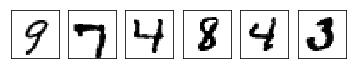

In [15]:
plot_images_separately(data[:6,0].data.cpu().numpy())

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


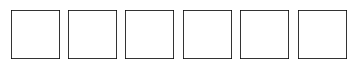

In [18]:
plot_images_separately(reconstructions[:6,0].data.cpu().numpy())